In [940]:
import numpy as np
from qutip import *
import matplotlib.pyplot as plt
from _funcs import *

import seaborn as sns
plt.rc('text', usetex=True)
sns.set()

def get_first_hit(array, x):
    # create a function that returs first hitting time of array >= x
    try: 
        return np.min(np.where(array>=x))
    except ValueError:
        return -1


# Gambling Demon

The demon will apply a $\pi/2$ pulse around the $\sigma_{x}$ axis. Ahead of time, he computes that it will cost some amount of work to perform this operation. He will then monitor the amount of work he puts into the system and stop it when it hits some critical threshold which he believes will maximise his free energy extraction.

We need to calculate all the sources of work in this example. First and foremost, we can acknowledge that the chemical work is zero. This leaves two sources of work from the drive and the measurement. The full Hamiltonian is given by:
$$
H(t) = \frac{\omega }{2} \sigma_{z} + \Omega\left(e^{-i\omega t}\sigma_{+} + e^{i \omega t}\sigma_{-}\right)\,,
$$
In the interaction picture and the rotating frame this becomes:
$$
H = \Omega \sigma_{x}\,.
$$
The drive work is given by:
$$
\dot{W}_{\rm drive} = {\rm tr}\left[\dot{H}(t)\rho(t)\right]
$$
which in the interaction, and rotating frame is given by:
$$
\dot{W}_{\rm drive} = \omega \Omega \langle \sigma_{y}\rangle\,.
$$
The measurement work is given by Manzano and Zambrini as:
$$
\dot{W}_{\rm meas} = \sqrt{\gamma} \xi(t) \left( \langle H \sigma_{y} \rangle - \langle H \rangle \langle \sigma_{y} \rangle \right) \approx \frac{\sqrt{\gamma} \omega \xi(t)}{2}\langle e^{i \omega t}\sigma_{+} - e^{-i \omega t}\sigma_{-}\rangle\,.
$$

In [1019]:
# Parameters
Gamma = 1
Omega = 2
omega = 100
dt = 0.0012
tf = np.pi/(2*Omega)
t = np.arange(0, tf, dt)

# Define system operators
sp = sigmap()
sm = sigmam()
sx = sigmax()
sz = sigmaz()
sy = sigmay()
g = sm*sp
e = sp*sm
H = Omega*sx
H0 = omega*sz/2

# define dissipator and Hamiltonian
c_ops = [1j*np.sqrt(Gamma) * sm]    

# steadystate
rho0 = fock(2, 1)
rhoss = steadystate(H, c_ops)

unconditional_result = mesolve(H, rho0, t, c_ops=c_ops, e_ops=[sy, sz, H0])
ez_un = unconditional_result.expect[1]
ey_un = unconditional_result.expect[0]
H0_un = unconditional_result.expect[2]

N_cutoff = 1

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0. 0.]
 [1. 0.]]

In [1007]:
Ht = Omega * (sx) + 0*omega * (sz/2)


sm

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0. 0.]
 [1. 0.]]

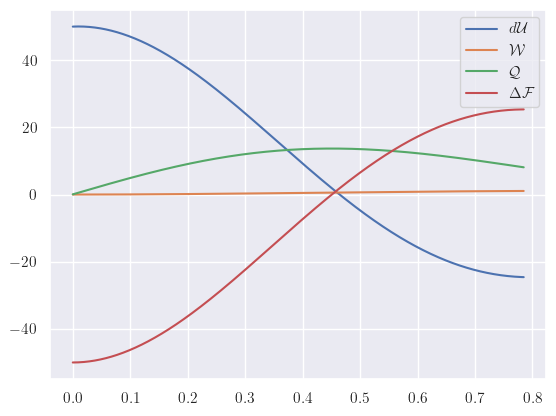

In [1008]:
# We can compute the necessary thermodynamic quantities
dW  = Omega*ey_un
dQ = - Gamma * H0_un
dU = dW + dQ

W = np.cumsum(dW)*dt
Q = np.cumsum(dQ)*dt

U = H0_un

plt.plot(t, dU, label=r'$d\mathcal{U}$')
plt.plot(t, W, label=r'$\mathcal{W}$')
plt.plot(t, Q, label=r'$\mathcal{Q}$')
plt.plot(t, U, label=r'$\Delta \mathcal{F}$')

plt.legend()
plt.show()

# We now want to set the threshold N to be equal to the final work computed over a pi/2 pulse

In [1009]:
N_cutoff = W[-1]/Omega
N_cutoff

0.5327171388210868

In [1010]:
# number of chargers to truncate at 
Nm = 20
dN = 0.06
N = np.arange(-20, Nm, dN)

# ------ Solve n-resolved method with absorbing boundary conditions ------ #
diff = DiffusiveEvolutionPntAbsorb(H, c_ops, 1, t, N, N_cutoff, kind='single')
Pn_vec = diff.solve(rho0)

Converting initial state to vector form


Evolution Superoperator: 100%|██████████| 654/654 [00:04<00:00, 157.10it/s]


In [1011]:
# Compute survival probability from analytic solution
P0 = np.sum(Pn_vec, axis=0)
dGt = -np.gradient(P0, dt)

# Compute mean and variance of distribution
Et = np.sum(dGt * t)*dt
Var = np.sum(dGt * t**2)*dt - Et**2

In [1089]:
ntraj = 4000

result = ssesolve(H, rho0, t, sc_ops=c_ops, e_ops=[H0, sy, -1j*sm, 1j*sp, sz], store_measurement=True, ntraj=ntraj, store_all_expect=True)

10.0%. Run time:   4.06s. Est. time left: 00:00:00:36
20.0%. Run time:   8.08s. Est. time left: 00:00:00:32
30.0%. Run time:  12.12s. Est. time left: 00:00:00:28
40.0%. Run time:  16.27s. Est. time left: 00:00:00:24
50.0%. Run time:  20.33s. Est. time left: 00:00:00:20
60.0%. Run time:  24.36s. Est. time left: 00:00:00:16
70.0%. Run time:  28.39s. Est. time left: 00:00:00:12
80.0%. Run time:  32.42s. Est. time left: 00:00:00:08
90.0%. Run time:  36.39s. Est. time left: 00:00:00:04
Total run time:  40.36s


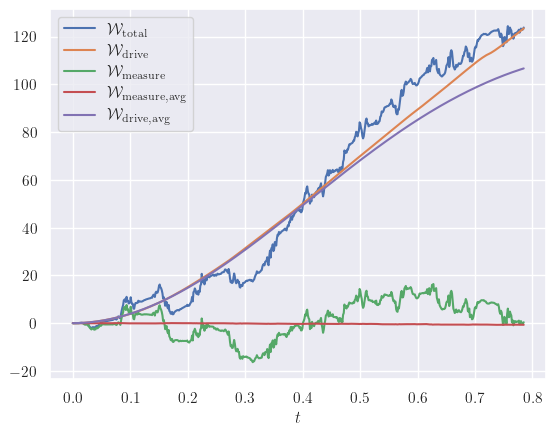

In [1101]:
xi = result.noise.T[0,0].T
sm_runs = result.runs_expect[:,2,:]
sp_runs = result.runs_expect[:,3,:]
sz_runs = result.runs_expect[:,4,:]
sy_runs = result.runs_expect[:,1,:]

omega = 100
W_measure = np.real((0.5*omega*np.sqrt(Gamma)*(np.exp(-1j*omega*t)*sm_runs + np.exp(1j*omega*t)*sp_runs) - omega*sz_runs*sy_runs/2)*xi/dt)
W_drive = np.real(omega*Omega*result.runs_expect[:,1,:]/np.sqrt(Gamma))
W_T = np.cumsum(W_measure + W_drive, axis=1)*dt

# average over 
W_measure_avg = np.mean(W_measure, axis=0)
W_drive_avg = np.mean(W_drive, axis=0)
W_T_avg = np.mean(W_T, axis=0)


Iy = np.real(np.array(result.measurement).reshape(ntraj, len(t)))

# Work without absorbing boundary conditions
W_e = omega*Omega*dt*np.cumsum(Iy, axis=1)/np.sqrt(Gamma)

ix = 6
plt.plot(t, W_T[ix], label=r'$\mathcal{W}_{\rm total}$')
plt.plot(t, np.cumsum(W_drive[ix])*dt, label=r'$\mathcal{W}_{\rm drive}$')
plt.plot(t, np.cumsum(W_measure[ix])*dt, label=r'$\mathcal{W}_{\rm measure}$')

plt.plot(t, np.cumsum(W_measure_avg)*dt, label=r'$\mathcal{W}_{\rm measure, avg}$')
plt.plot(t, np.cumsum(W_drive_avg)*dt, label=r'$\mathcal{W}_{\rm drive, avg}$')

plt.legend()
plt.xlabel(r'$t$')

plt.show()



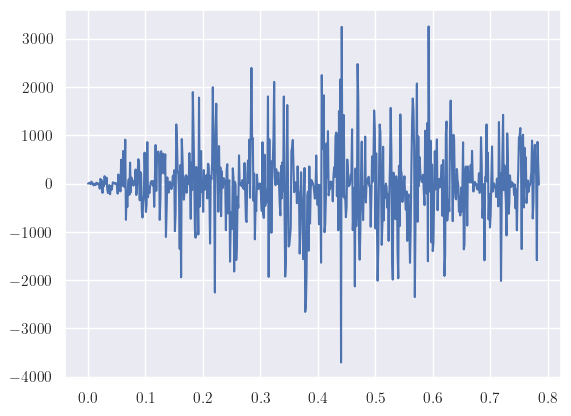

In [1087]:
plt.plot(t, W_measure[2], label=r'$\mathcal{W}_{\rm measure, avg}$')

In [1061]:
# get measurement results
Iy = np.real(np.array(result.measurement).reshape(ntraj, len(t)))
sye = np.real(np.array(result.runs_expect[:, 1, :]).reshape(ntraj, len(t)))
xi = result.noise.T[0,0].T

# Work without absorbing boundary conditions
W_e = Omega*dt*np.cumsum(Iy, axis=1)/np.sqrt(Gamma)

# compute work according to Manzano
Power_measure = Omega*np.sqrt(Gamma)*xi*(1-sye**2)/dt
W_measure = np.real(np.cumsum(Power_measure, axis=1))*dt
W_drive = Omega*np.real(np.cumsum(result.runs_expect[:, 1, :], axis=1))*dt

# Get first hitting times
inds = np.array([get_first_hit(mi, Omega*N_cutoff) for mi in W_e])
inds_f = inds[inds != None]

# Get first hitting times
hitting_times = t[list(inds_f)]

# Make a copy of Iy to compube absorbed trajectories
Iy_copy = Iy.copy()
sye_copy = sye.copy()
W_final = []
W_final_real = []
W_measure_final = []
dF_final_hit = []
dF_final_T = []

for i in range(ntraj):
    if inds[i]==-1:
        # if time boundary is reached
        W_final.append(Omega*dt*np.sum(Iy[i, :])/np.sqrt(Gamma))
        W_final_real.append(Omega*dt*np.sum(sye[i, :])/np.sqrt(Gamma))
        

        dF_final_T.append(np.real(result.runs_expect[i,0, -1]))
    else:
        # if hitting boundary is reached 
        Iy_copy[i, inds[i]:] = 0
        sye_copy[i, inds[i]:] = 0
        dF_final_hit.append(np.real(result.runs_expect[i,0, inds[i]]))

# Work with abosrbing boundary conditions
W_ab = Omega*dt*np.cumsum(Iy_copy, axis=1)/np.sqrt(Gamma)
W_ab_real = Omega*dt*np.cumsum(sye_copy, axis=1)/np.sqrt(Gamma)
dF_final_hit = np.array(dF_final_hit)
dF_final_T = np.array(dF_final_T)

In [1062]:
# Integrate first hitting time distribution to t_cutoff
PT = np.sum(dGt)*dt
Wbar = np.mean(W_final)
Wbar_real = np.mean(W_final_real)

# Compute mean work 
W_T = Omega*N_cutoff * PT  +  (1-PT)*Wbar
W_T_real = np.mean(W_ab_real)*PT + (1-PT)*Wbar_real

# compute norm of the work distribution
Pn_Norm = np.sum(Pn_vec[:,-1])

ValueError: x and y must have same first dimension, but have shapes (343,) and (351,)

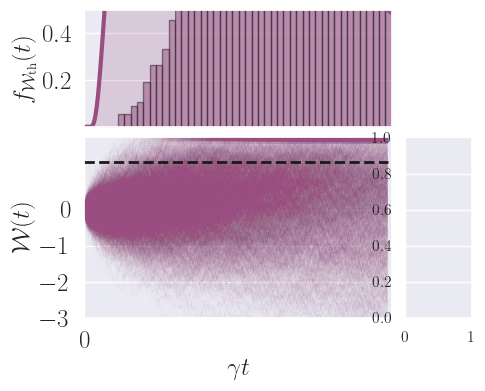

In [1064]:
fig = plt.figure(figsize=(5, 4))
gs = fig.add_gridspec(5, 5)

color = [0.6, 0.3, 0.5]
fs = 18

ax1 = fig.add_subplot(gs[:2, :4])
ax1.plot(t, dGt, color=color, linewidth=3)
ax1.fill_between(t, dGt, color=color, alpha=0.2)
ax1.hist(hitting_times, bins=50, color=color, alpha=0.5, density=True, edgecolor='k')

plt.xticks(np.arange(0, tf, 0.2), [])
plt.xlim(0, tf-0.1)
plt.yticks(np.arange(0.2, 0.7, 0.2), fontsize=fs)
plt.ylim(0, 0.5)
plt.ylabel(r'$f_{\mathcal{W}_{\rm th}}(t)$', fontsize=fs)

ax2 = fig.add_subplot(gs[2:5, :4])
ax2.plot(t, W_ab[:3000].T, color=color, linewidth=0.1, alpha=0.1)
plt.hlines(W_T, 0, tf, color='k', linewidth=2, linestyle='--')

plt.ylim(-3, Omega*N_cutoff)
plt.yticks(np.arange(-3, N_cutoff, 1), fontsize=fs)
plt.xticks(np.arange(0, tf, 1), fontsize=fs)
plt.xlim(0, tf+0.01)
plt.ylabel(r'$\mathcal{W}(t)$', fontsize=fs)
plt.xlabel(r'$\gamma t$', fontsize=fs)

ax3 = fig.add_subplot(gs[2:, 4])
ax3.plot(Pn_vec[:, -1]/(Omega*dN*Pn_Norm), Omega*N[N<N_cutoff], color='b', linewidth=3)
ax3.hist(W_final, bins=50, orientation='horizontal', color='b', alpha=0.5, density=True, edgecolor='k')
plt.yticks(np.arange(-5, Omega*N_cutoff+1, 1),[])
plt.ylim(-3, Omega*N_cutoff)
plt.xticks(np.arange(0.0, 1, 0.5), fontsize=fs)

plt.xlabel(r'$P(\mathcal{W}, T)$', fontsize=fs)
plt.subplots_adjust(wspace=0, hspace=0)

plt.show()

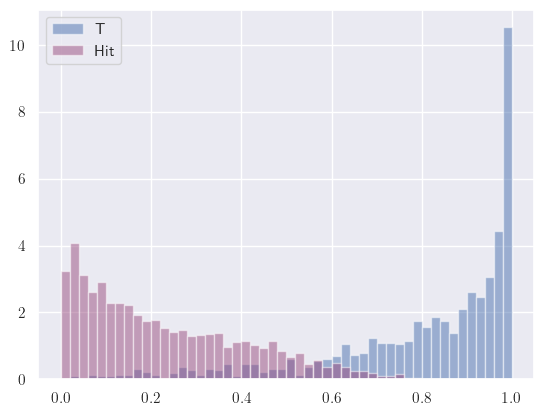

In [890]:
plt.hist(dF_final_T, bins=50, density=True, label='T', range=(0, 1), color='b', alpha=0.5)
plt.hist(dF_final_hit, bins=50, density=True, label='Hit', range=(0, 1), color=color, alpha=0.5)

plt.legend()

plt.show()

In [891]:
dF_T = np.mean(dF_final_T)
dF_hit = np.mean(dF_final_hit)
dFbar = dF_hit*PT + (1-PT)*dF_T

print('Gambling dF_T = ', dFbar)
print('Gambling W_T = ', W_T)
print('Gambling Wbar real = ', np.mean(W_T_real))

print('Theory dF_T = ', U[-1])
print('Theory W_T = ', W[-1])


print(W[-1]/U[-1])
print(W_T_real/dFbar)

Gambling dF_T =  0.4023144663821422
Gambling W_T =  0.4438542434704805
Gambling Wbar real =  0.4845568012393323
Theory dF_T =  0.753548723505205
Theory W_T =  1.0654342776421737
1.4138890351856783
1.2044230116723456


In [911]:
sye = result.runs_expect[:, 1, :]
xi = result.noise.T[0,0].T
Power_measure = 1*np.sqrt(Gamma)*xi*(1-sye**2)/dt
W_measure = Omega*np.real(np.cumsum(Power_measure, axis=1))*dt
W_chem = np.real(result.runs_expect[:, 0, :])
W_drive = Omega*np.real(np.cumsum(result.runs_expect[:, 1, :], axis=1))*dt

W_total = 0*W_chem + W_drive + W_measure

# ix = 5
# plt.plot(t, W_measure[ix].T, color=color, linewidth=1, alpha=1)
# plt.plot(t, W_drive[ix].T, color='r')
# plt.plot(t, W_chem[ix].T, color='g', linewidth=1, alpha=1)
# plt.plot(t, W_e[ix].T, color='k', linewidth=1, alpha=1)
# plt.plot(t, W_total[ix].T, color='k', linewidth=0.5, linestyle='-')
# plt.show()

In [912]:
W_total_e = np.mean(W_total, axis=0)

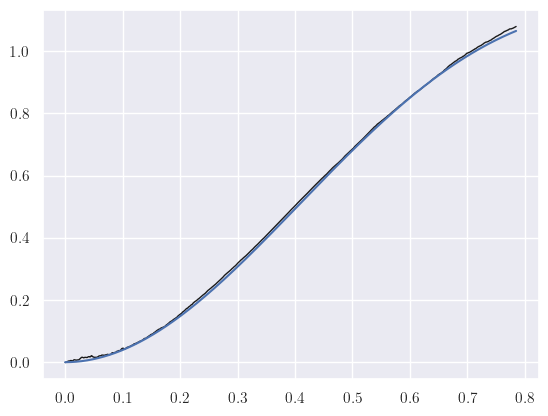

In [913]:
plt.plot(t, W_total_e, color='k', linewidth=1, linestyle='-')
plt.plot(t, W)
plt.show()

No
